# Lista prática I

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynp

## Vizinhos mais próximos

**Exercício 1.** O código abaixo carrega o dataset MNIST, que consiste em imagens de dígitos entre $0$ e $9$. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 5) e reporte a acurácia para cada valor de $k$. Lembre que a acurácia é o percentual de amostras classificadas corretamente. Notavelmente, as entradas do MNIST tem dimensão relativamente alta (64). Plote uma imagem com a variância amostral dos pixels das imagens e comente. Também mostre as imagens classificadas de maneira errônea e comente.

In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits, make_moons
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)

@dataclass
class Dataset:
    features_train: np.ndarray 
    features_test: np.ndarray  
    labels_train: np.ndarray   
    labels_test: np.ndarray

# Import dataset and separate train/test subsets
mnist = Dataset(*train_test_split(
    *load_digits(return_X_y=True),
    random_state=SEED,
))

In [102]:
# Método do k-NN
def knn(X_train, y_train, X_test, k):
    # Matrizes que compõem o cálculo matricial das distâncias entre os pontos de treino e teste
    aux1 = np.diag(X_train @ X_train.T).reshape(-1, 1) @ np.ones(X_test.shape[0]).reshape(1, -1)
    aux2 = -2 * X_train @ X_test.T
    aux3 = np.ones(X_train.shape[0]).reshape(-1, 1) @ np.diag(X_test @ X_test.T).reshape(1, -1)
    
    # Calculando a matriz de distâncias
    # O elemento (i, j) dessa matriz é a distância euclidiana entre o i-ésimo ponto do treino e
    # o j-ésimo ponto do teste, de modo que cada coluna é o vetor de distâncias do j-ésimo
    # ponto de teste a todos os pontos de treino
    distances = np.sqrt(aux1 + aux2 + aux3)

    # Encontrando a vizinhança de cada ponto de teste
    neighbors = np.argsort(distances, axis = 0)[:k, :]
    # Pegando os rótulos desses vizinhos
    neighbors_labels = y_train[neighbors]
    # Calculando as predições dos pontos de teste como a moda dos rótulos de cada vizinhança
    y_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis = 0, arr = neighbors_labels)

    return y_pred

In [103]:
# Número de pontos de teste
n_of_test_points = mnist.labels_test.shape[0]
# Salvando o melhor número de vizinhos
best_k = 0
# Salvando a melhor acurácia
best_accuracy = 0
# Salvando as melhores predições
best_y_pred = None

# Para cada número de vizinhos...
for k in range(1, 11):
    # Calcula as predições para o conjunto de teste
    y_pred = knn(mnist.features_train, mnist.labels_train, mnist.features_test, k)
    # Calcula a acurácia
    accuracy = np.sum(y_pred == mnist.labels_test)/n_of_test_points
    print("Número de vizinhos:", k, "; Acurácia:", accuracy)
    # Se for a melhor acurácia até agora, salva as variáveis
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        best_y_pred = y_pred

Número de vizinhos: 1 ; Acurácia: 0.9822222222222222
Número de vizinhos: 2 ; Acurácia: 0.9844444444444445
Número de vizinhos: 3 ; Acurácia: 0.9866666666666667
Número de vizinhos: 4 ; Acurácia: 0.9866666666666667
Número de vizinhos: 5 ; Acurácia: 0.9933333333333333
Número de vizinhos: 6 ; Acurácia: 0.9955555555555555
Número de vizinhos: 7 ; Acurácia: 0.9933333333333333
Número de vizinhos: 8 ; Acurácia: 0.9888888888888889
Número de vizinhos: 9 ; Acurácia: 0.9866666666666667
Número de vizinhos: 10 ; Acurácia: 0.9866666666666667


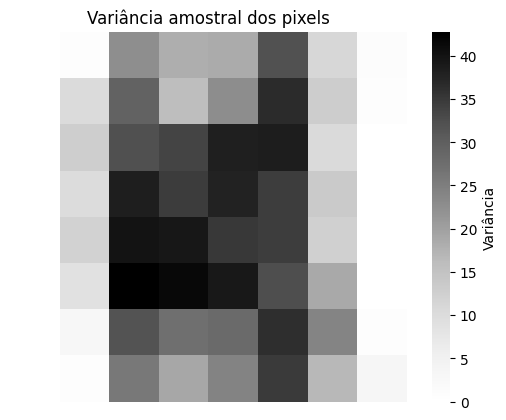

In [104]:
# Juntando os pontos de treino e de teste
all_points = np.vstack((mnist.features_train, mnist.features_test))

# Calculando a variância amostral
# sample_variance = (1/(all_points.shape[0] - 1)) * np.sum((all_points - all_points.mean(axis = 0))**2, axis = 0)
sample_variance = np.var(all_points, axis = 0, ddof = 1).reshape((8, 8))

# Plotando a imagem da variância amostral como um heatmap
ax = sns.heatmap(sample_variance, cmap = "Greys", xticklabels = False, yticklabels = False)
ax.set_title("Variância amostral dos pixels")
ax.collections[0].colorbar.set_label("Variância")
plt.show()

Rótulo: 9 ; Predição: 4


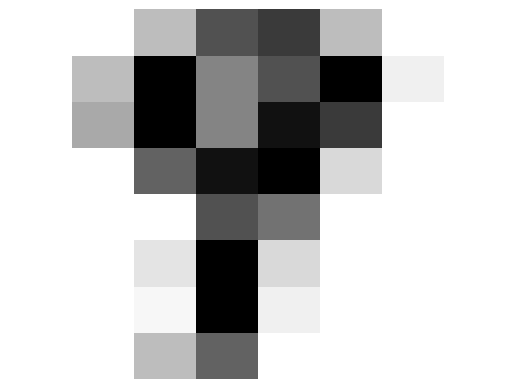

Rótulo: 9 ; Predição: 5


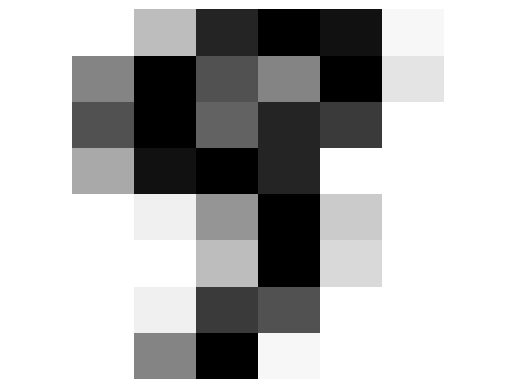

In [105]:
# Pegando os índices dos pontos classificados incorretamente pelo melhor modelo
wrong_classified = np.where([best_y_pred != mnist.labels_test])[1]

# Exibindo os rótulos verdadeiro e previsto e a imagem de cada um desses pontos
for wrong_index in wrong_classified:
    image = mnist.features_test[wrong_index].reshape((8, 8))
    sns.heatmap(image, cmap = "Greys", xticklabels = False, yticklabels = False, cbar = False)
    print("Rótulo:", mnist.labels_test[wrong_index], "; Predição:", best_y_pred[wrong_index])
    plt.show()

**Resposta:** Curiosamente, as duas imagens classificadas erroneamente são do dígito 9. Na primeira, classificada como um 4, podemos ver uma parte superior do círculo do 9 um pouco fraca e uma "perninha" não tão puxada para a esquerda, o que pode ter levado esse ponto a se aproximar mais dos números 4 (não dessa forma como é escrito pelo computador, mas da forma manuscrita). Já com relação à segunda imagem, classificada como um 5, não sei dizer porque esse ponto está mais próximo dos 5s do que dos 9s. Talvez o círculo um pouco pequeno?

**Exercício 02.** O código abaixo carrega o dataset "two moons", que consiste de amostras bidimensionais divididas em duas classes. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 10). Plote a superfície de decisão para cada valor de $k$. Como $k$ influencia na suavidade dessas superfícies?

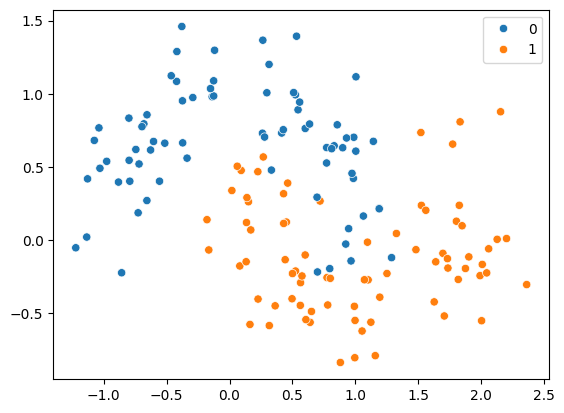

In [106]:
# Import dataset and separate train/test subsets
moon = Dataset(*train_test_split(
    *make_moons(n_samples=200, shuffle=True, noise=0.25, random_state=SEED),
    random_state=SEED,
))

# Let's also plot the moon dataset, for you to take a look at it.
sns.scatterplot(
    x=moon.features_train[:, 0],
    y=moon.features_train[:, 1],
    hue=moon.labels_train,
)
plt.show()

In [108]:
# Número de pontos de teste
n_of_test_points = moon.labels_test.shape[0]
# Salvando o melhor número de vizinhos
best_k = 0
# Salvando a melhor acurácia
best_accuracy = 0
# Salvando as melhores predições
best_y_pred = None

# Para cada número de vizinhos...
for k in range(1, 11):
    # Calcula as predições para o conjunto de teste
    y_pred = knn(moon.features_train, moon.labels_train, moon.features_test, k)
    # Calcula a acurácia
    accuracy = np.sum(y_pred == moon.labels_test)/n_of_test_points
    print("Número de vizinhos:", k, "; Acurácia:", accuracy)
    # Se for a melhor acurácia até agora, salva as variáveis
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
        best_y_pred = y_pred

Número de vizinhos: 1 ; Acurácia: 0.94
Número de vizinhos: 2 ; Acurácia: 0.92
Número de vizinhos: 3 ; Acurácia: 0.92
Número de vizinhos: 4 ; Acurácia: 0.92
Número de vizinhos: 5 ; Acurácia: 0.92
Número de vizinhos: 6 ; Acurácia: 0.9
Número de vizinhos: 7 ; Acurácia: 0.94
Número de vizinhos: 8 ; Acurácia: 0.92
Número de vizinhos: 9 ; Acurácia: 0.94
Número de vizinhos: 10 ; Acurácia: 0.94


In [ ]:
# Criando dados com todas as combinações de valores dos eixos
all_x = np.arange(-1.5, 2.5, 0.03)
all_y = np.arange(-1, 1.5, 0.03)

X, Y = np.meshgrid(all_x, all_y)
all_coordinates = np.column_stack([X.ravel(), Y.ravel()])

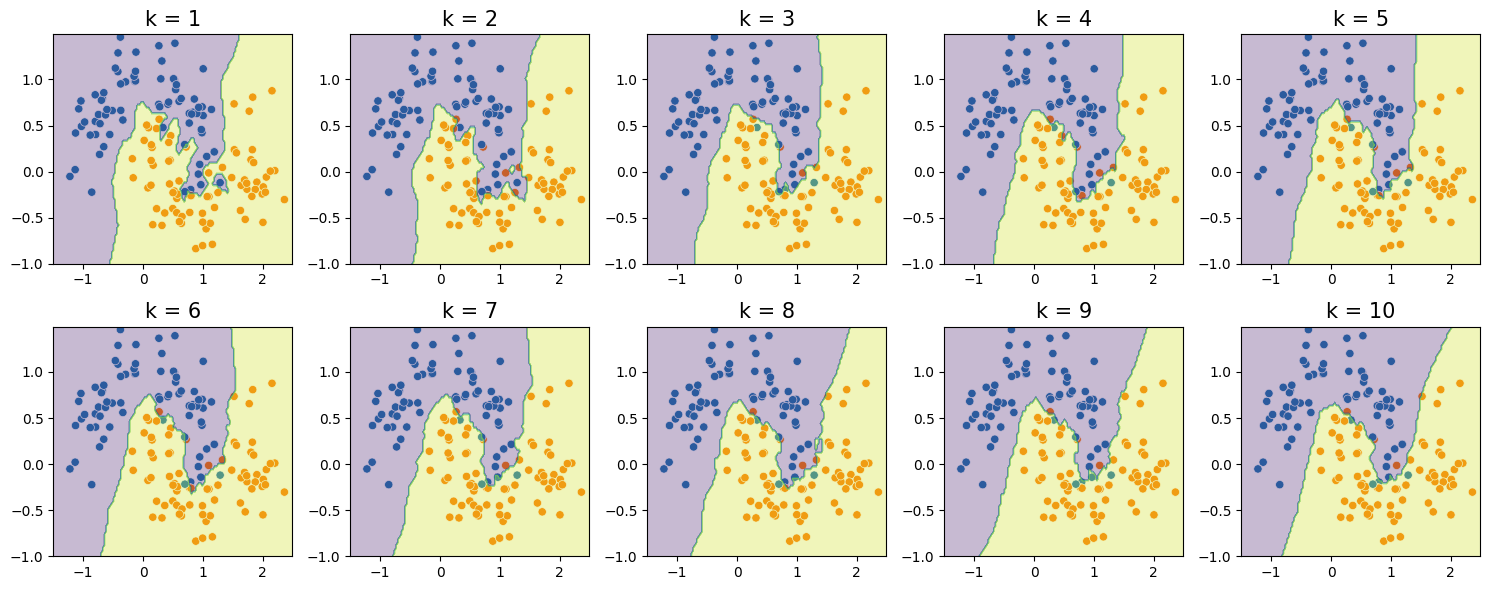

In [142]:
# Iniciando o subplots
fig, axes = plt.subplots(2, 5, figsize = (15, 6))

# Para cada valor de k...
for k in range(1, 11):
    # Calcula as predições para todas as coordenadas do gráfico
    all_y_preds = knn(moon.features_train, moon.labels_train, all_coordinates, k).reshape(X.shape)
    # Seta o subplot correto
    ax = axes[(k-1)//5, (k-1)%5]
    # Plota os dados
    sns.scatterplot(
        x = moon.features_train[:, 0],
        y = moon.features_train[:, 1],
        hue = moon.labels_train,
        ax = ax
    )
    # Plota a fronteira
    ax.contourf(X, Y, all_y_preds, alpha = 0.3)
    # Ajusta o gráfico
    ax.legend([], [], frameon = False)
    ax.set_title(f"k = {k}", fontsize = 15)

plt.tight_layout()
plt.show()

**Resposta:** Pode-se notar que, quanto maior a vizinhança definida, mais suave torna-se a fronteira de decisão. Isso se deve ao fato de que, com mais vizinhos participando da votação majoritária de decisão do rótulo de um ponto, mais trocas de vizinho são necessárias para que essa votação possa inverter-se e o rótulo escolhido possa mudar, fazendo com que um ponto precise "movimentar-se" mais para que isso aconteça, o que torna a fronteira mais regular.

# Regressão linear

**Exercício 1.** Deixamos à sua disposição o dataset ["California Housing"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), dividio em treino, teste e validação.
O modelo que você utilizará para aproximar a relação funcional entre as features e as labels é o modelo linear, i.e., $\mathbf{y} = X\theta$.
Entretanto, você deve estimar seus parâmetros (minimizando o *mean squared error*) com **dois algoritmos diferentes**.
Uma implementação deve estimar $\theta$ por meio de **Stochastic Gradient Descent (SGD)** e, a outra, por meio de **Ordinary Least Squares (OLS)**, ou seja, utilizar a solução em fórmula fechada vista em aula.

Para o SGD, o ponto inicial deve ser escolhido aleatoriamente e o algoritmo deve parar quando a norma da diferença entre duas estimativas consecutivas de $\theta$ for menor do que um $\varepsilon > 0$ previamente especificado.
Para o experimento a seguir, fixe $\varepsilon$ em um valor pequeno (por exemplo, alguma potência de $1/10$) para a qual o algoritmo convirja no máximo em alguns minutos para uma solução com perda pequena.

Para diferentes tamanhos de minibatch (por exemplo $\{2^{j}: 1 \leq j \leq 7\}$), plote um gráfico representando o valor da perda $ L(\hat{\theta}) = \frac{1}{n} \lVert X \hat{\theta} - \mathbf{y} \rVert^{2}$ no conjunto de validação em função do número de epochs. Mostre também o valor ótimo obtido com OLS. Comente os resultados e o efeito tamanho do mini-batch, e.g., no tempo de treinamento. Reporte valores nos conjuntos de treino, validação e teste.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


SEED = 42
np.random.seed(SEED)


features, labels = fetch_california_housing(return_X_y=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size==0.25
)
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25
)

**Exercício 2.** Agora, você deve implementar uma **Rede RBF** com função de base Gaussiana (veja as notas de aula).
Para os centróides, utilize o output de um modelo de clusterização por K médias, por meio da função que disponibilizamos, como a seguir:

In [ ]:
def k_means_factory(n_clusters: int) -> KMeans:
    return KMeans(n_clusters=n_clusters, n_init="auto")

k_means_model = k_means_factory(n_clusters=2)
dumb_data = np.array(
    [[1, 2],
     [1, 4],
     [1, 0],
     [10, 2],
     [10, 4],
     [10, 0]]
)
k_means_model.fit(dumb_data)
cluster_centers = k_means_model.cluster_centers_
print(cluster_centers) # Shape (n_clusters, n_features)

Para determinar o melhor valor de $k$ para o algoritmo de clusterização, treine o modelo (usando a fórmula de OLS) com diferentes valores e escolha o que possuir o menor erro de validação. Faça um gráfico mostrando o valor do erro de validação para diferentes valores de $k$. Mostre também a performance do modelo escolhido no conjunto de teste. Compare com o modelo linear simples da questão anterior. Discuta os resultados.

Para definir o valor do hiper-parâmetro $\gamma$, use a seguinte heurística --- que pode ser achado no livro "Neural Networks", por Simon Haykin:

$$
\gamma = \frac{1}{d_\text{max}^2},
$$

onde $d_\text{max}$ é a maior distância entre um par de centróides. Note que o valor costuma mudar para $k$'s diferentes.


## Regressão logística

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disse, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para (potencialmente) facilitar sua vida: use PyTorch, Adam como otimizador (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use binary_cross_entropy_with_logits para implementar a -log verossimilhança, use torch.autograd.functional para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula a vontade. Verifique a documentação de binary_cross_entropy_with_logits para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [ ]:
data =  load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1) 
y = torch.tensor(data.target).float()

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]